# Method: Koopman Autoencoders
# Dataset: Lorenz-96, F = 8
# Purpose: Prediction

# 1. Set-up

In [1]:
# GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

# Package
import sys
sys.path.append("../..")

In [2]:
from create_data import load_data
from utils import * # Number of testing samples
import numpy as np
import matplotlib.pyplot as plt
from time import time, localtime, strftime

from functools import partial

import jax
from jax import jit, value_and_grad
import jax.numpy as jnp
from jax import random
from jax.example_libraries import optimizers
import jax.example_libraries.stax as stax
from jax.example_libraries.stax import Dense, Relu, Tanh
from jax.nn.initializers import glorot_normal

In [3]:
SEED = 42

In [4]:
train, test = load_data("Lorenz 96, F = 8", "../../data/lorenz8", 0.5)

In [5]:
print(f"Train size: {train.data.shape}")
print(f"Test size: {test.data.shape}")

Train size: (90000, 40)
Test size: (90000, 40)


**Create test set**

In [6]:
L_forecast_test = 400   # steps to forecast forward (when testing)

In [7]:
np.random.seed(1)

data_test = test.data

T_test, data_dim = data_test.shape
possible_idx = T_test - (L_forecast_test + 1) # minus number of steps forward, and the warm-up period
T_indices = np.random.randint(0, possible_idx, size = NUM_TEST)

t_past_batch = np.repeat(T_indices[:, None], WARM_UP_TEST, axis = 1).astype(int) # 200 warmup 
t_pred_batch = (T_indices[:, None] + np.arange(1, 1 + L_forecast_test)[None, :].astype(int))

X_test = data_test[t_past_batch]
y_test = data_test[t_pred_batch]

In [8]:
print(f"Test input size: {X_test.shape}")  # Number of test points x input length x dim
print(f"Test output size: {y_test.shape}") # Number of test points x horizon x dim

Test input size: (100, 2000, 40)
Test output size: (100, 400, 40)


# 2. Koopman Autoencoder Implementation

In [13]:
def Dense_no_bias(out_dim, W_init = glorot_normal()):
    """Layer constructor function for a dense (fully-connected) layer."""
    def init_fun(rng, input_shape):
        output_shape = input_shape[:-1] + (out_dim,)
        k1, k2 = random.split(rng)
        W = W_init(k1, (input_shape[-1], out_dim))
        return output_shape, W
    def apply_fun(params, inputs, **kwargs):
        W = params
        return jnp.dot(inputs, W)
    return init_fun, apply_fun

In [14]:
def get_params(hidden_state_list, max_lag, lambda_list, seed, batch_size, num_epoch, lr_schedule, 
               early_stopping = EARLY_STOPPING):
    assert len(num_epoch) == len(lr_schedule)
    
    def create_network():
        encoder_init, encoder = stax.serial(
            Dense(p1), Tanh,  
            Dense(p2), Tanh,
            Dense(p3), Tanh,
            Dense(kappa))
        decoder_init, decoder = stax.serial(
            Dense(p3), Tanh,
            Dense(p2), Tanh,
            Dense(p1), Tanh,
            Dense(data_dim))
        forward_init, forward = stax.serial(
            Dense_no_bias(kappa))
        backward_init, backward = stax.serial(
            Dense_no_bias(kappa))

        # initialization
        enc_init_rng, dec_init_rng, forward_init_rng, backward_init_rng = random.split(key, num = 4)

        enc_in_shape = (-1, data_dim)
        dec_in_shape = (-1, kappa)
        forward_in_shape = (-1, kappa)
        backward_in_shape = (-1, kappa)
        _, enc_params = encoder_init(enc_init_rng, enc_in_shape)
        _, dec_params = decoder_init(dec_init_rng, dec_in_shape)
        _, fwd_params = forward_init(forward_init_rng, forward_in_shape)
        _, bwd_params = backward_init(backward_init_rng, backward_in_shape)

        network = (encoder, decoder, forward, backward)
        params = (enc_params, dec_params, fwd_params, bwd_params)
        return network, params
    
    def training(init_params):
        @jit
        def loss(params, batch):
            """
            each batch has dimension Batch_size x (max_lag+1) x dim
            """
            # unpack parameters
            enc_params, dec_params, fwd_params, bwd_params = params
            lambda_id, lambda_fwd, lambda_bwd, lambda_con = lambda_list

            loss_id, loss_fwd, loss_bwd, loss_con = 0, 0, 0, 0

            # AUTOENCODER
            f_start = batch[:,0,:]
            f_target = batch[:,0,:]
            f_encoded = encoder(enc_params, f_start)
            f_predict = decoder(dec_params, f_encoded)
            loss_id = 0.5 * jnp.mean((f_predict - f_target)**2)

            # FORWARD
            f_start = batch[:,0,:]
            f_encoded = encoder(enc_params, f_start)
            for t_steps in range(1, max_lag+ 1):
                # simulate forward
                f_encoded = forward(fwd_params, f_encoded)
                f_predict = decoder(dec_params, f_encoded)
                f_target = batch[:,t_steps,:]
                loss_fwd += 0.5 * jnp.mean((f_predict - f_target)**2)

            loss_fwd = loss_fwd / max_lag

            # BACKWARD
            f_start = batch[:,-1,:]
            f_encoded = encoder(enc_params, f_start)
            for t_steps in range(1, max_lag + 1):
                f_encoded = backward(bwd_params, f_encoded)
                f_predict = decoder(dec_params, f_encoded)
                f_target = batch[:,-t_steps-1,:]
                loss_bwd += 0.5 * jnp.mean((f_predict - f_target)**2)

            loss_bwd = loss_bwd / max_lag

            # CONSISTENT
            for k in range(1, kappa + 1):
                C_upper = fwd_params[0][:k, :]
                D_left = bwd_params[0][:, :k]
                C_left = fwd_params[0][:, :k]
                D_upper = bwd_params[0][:k, :]

                I_k = jnp.identity(k)

                loss_con += (jnp.sum((D_upper @ C_left - I_k)**2) + jnp.sum((C_upper @ D_left - I_k)**2)) / (2 * k)

            return lambda_id * loss_id + lambda_fwd * loss_fwd + lambda_bwd * loss_bwd + lambda_con * loss_con
    
        @jit
        def step(i, opt_state, batch):
            params = get_params(opt_state)
            value, g = value_and_grad(loss)(params, batch)
            opt_state = opt_update(i, g, opt_state)
            return get_params(opt_state), opt_state, value
        
        def make_forecast(params, batch, L_forecast):
            enc_params, dec_params, fwd_params, bwd_params = params

            preds = []
            f_start = batch[:, 0, :]
            f_encoded = encoder(enc_params, f_start)
            for t in range(L_forecast):
                f_encoded = forward(fwd_params, f_encoded)
                f_predict = decoder(dec_params, f_encoded)
                preds.append(f_predict)
            return np.swapaxes(preds, 0, 1)      
        
        def mse(params, x_batch, y_truth):
            """
            For each time-series in a batch, forecasts over a finite horizon 
            and compute the MSE. Primarily used for validation calculation

            args:
            ====
             params: neural parameters
             x_batch: a batch of inputs with dimension (batch_size, T_past, dim_data)
             y_truth: a batch of values to forecasts with dimension (batch_size, T_future, dim_data)

            outputs:
            =======
             MSE: MSE between forecasts and targets
            """

            # horizon of the forecast
            L_forecast = y_truth.shape[1]    
            y_pred = make_forecast(params, x_batch, L_forecast_test)
            
            #compute MSE
            error = y_pred - y_truth
            mu_loss = np.mean(error**2)
            return mu_loss 
        
        start = time()
        best_params = init_params
        overall_best_mse = 99999999
        
        # train/val split
        t_size = int(0.9 * train_size)
        v_size = train_size - t_size
        T_indices_val = np.arange(t_size, train_size - (L_forecast_test + max_lag))
        t_start_val = T_indices_val[::10]
        t_past_batch_val = (t_start_val[:,None] + np.arange(max_lag)[None,:]).astype(int) 
        t_pred_batch_val = (t_start_val[:,None] + np.arange(max_lag, max_lag + L_forecast_test)[None,:]).astype(int) 
        x_val = x[t_past_batch_val]
        y_val = y[t_pred_batch_val]
        
        print("Backpropogation start", end = "\n\n")
        for i, lr in enumerate(lr_schedule):
            opt_init, opt_update, get_params = optimizers.adam(step_size = lr) 
            opt_state = opt_init(best_params)
            counter = 0
            best_mse = 999999999
            
            for epoch in range(num_epoch[i]):
                e_start = time()
                
                # randomize the order of the data
                T_indices = np.arange(t_size - max_lag - 1)
                np.random.shuffle(T_indices)
                
                # training
                loss_epoch_train = []
                
                for k in range(t_size // batch_size + 1):
                    # create a batch of data
                    t_start = T_indices[np.arange(k*batch_size, (k+1)*batch_size).astype(int) % len(T_indices)] # start of each time series in the batch

                    # create 2d array of dimension (batch_size, max_lag + 1) containing all the time indices
                    t_batch = (t_start[:,None] + np.arange(max_lag + 1)[None,:]).astype(int) # transposes data

                    #create batch of dimension (batch_size,  max_lag + 1, data_dim)
                    x_batch = x[t_batch]  

                    params, opt_state, loss_current = step(k, opt_state, x_batch)
                    loss_epoch_train.append(loss_current.item())
                
                mse_train = np.mean(loss_epoch_train)

                # validation
                mse_val = mse(params, x_val, y_val)
                
                if best_mse > mse_val: # Improvement
                    counter = 0
                    best_mse = mse_val
                    best_params = params
                else:
                    counter += 1
                
                e_end = time()
                if (epoch + 1) % 10 == 0 or (counter == 0 and epoch >= 30):
                    print(f"Epoch {epoch + 1}: Time taken = {e_end - e_start:.2f} | Train loss = {mse_train:.7f} | Val loss = {mse_val: .7f}")
                if counter >= early_stopping:
                    print(f"EARLY STOPPING. Epoch {epoch + 1}: Train loss = {mse_train:.7f} | Val loss = {mse_val: .7f}")
                    break
            
            print(f"Best Validation MSE: {best_mse:.7f}")
            
            if best_mse < overall_best_mse: # Best round so far
                print("IMPROVED VALIDATION MSE")
                overall_best_mse = best_mse
                overall_best_params = best_params
            print()
            
        end = time()
        print(f"Total time: {end - start:.2f}")

        return overall_best_params
            
    start = time()
    x, y = train.data[:-1], train.data[1:]
    train_size, data_dim = x.data.shape
    p1, p2, p3, kappa = hidden_state_list # 4 layers (including bottleneck)
        
    np.random.seed(seed)
    key = jax.random.PRNGKey(seed)
    
    (encoder, decoder, forward, backward), params = create_network()
    final_params = training(params)
    
    return final_params, (encoder, decoder, forward, backward)

In [15]:
def get_test_pred(data_test, params, network):
    start = time()
    
    (encoder, decoder, forward, backward) = network
    enc_params, dec_params, fwd_params, bwd_params = params
    
    num_data_test, L_past, data_dim = data_test.shape # testing ex, # steps used before, dim of data

    preds = []
    f_start = data_test[:, 0, :]
    f_encoded = encoder(enc_params, f_start)
    for t in range(L_forecast_test):
        f_encoded = forward(fwd_params, f_encoded)
        f_predict = decoder(dec_params, f_encoded)
        preds.append(f_predict)
    end = time()
    print(f"Time taken: {end - start:.2f}")
    return np.swapaxes(preds, 0, 1)

# 3. Parameter tuning

There are 3 parameters to tune
- hidden_size - size of the hidden layer
- max_lag - Number of steps calculated for forward and backward dynamics
- loss_weights - [encoder, forward, backward, consistent] loss

## 3.1 hidden_size

**Parameters**
- hidden_size varied
- max_lag = 8
- loss_weights = [1, 1, 0.1, 0.01]

In [12]:
max_lag = 8
loss_weights = [1, 1, .1, .01]

batch_size = 128
epoch_list = [50, 50, 50]
lr_list = [1e-3, 1e-4, 1e-5]

In [13]:
res_folder = os.path.join("results", "koopman")

### 3.1.1 hidden_size = [32, 16, 16, 8]

In [15]:
hidden_size = [32, 16, 16, 8]

In [16]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 2.30 | Train loss = 0.6903426 | Val loss =  1.0135039
Epoch 20: Time taken = 2.30 | Train loss = 0.6829529 | Val loss =  1.1852436
Epoch 30: Time taken = 2.29 | Train loss = 0.6576700 | Val loss =  1.2964909
EARLY STOPPING. Epoch 36: Train loss = 0.6216998 | Val loss =  1.2180668
Best Validation MSE: 0.9416079
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 2.36 | Train loss = 0.6870266 | Val loss =  1.0443514
Epoch 20: Time taken = 2.39 | Train loss = 0.6650108 | Val loss =  1.4133657
Epoch 30: Time taken = 2.36 | Train loss = 0.6205389 | Val loss =  1.2821134
EARLY STOPPING. Epoch 34: Train loss = 0.6145068 | Val loss =  1.4347833
Best Validation MSE: 0.9622290

Epoch 10: Time taken = 2.45 | Train loss = 0.6777638 | Val loss =  1.4293896
Epoch 20: Time taken = 2.32 | Train loss = 0.6524019 | Val loss =  1.3216854
Epoch 30: Time taken = 2.79 | Train loss = 0.6125868 | Val loss =  1.4783764
EARLY STOPPING. Epoch 31: Train loss = 0.6111334 |

In [17]:
mean_pred = get_test_pred(X_test, params, network)

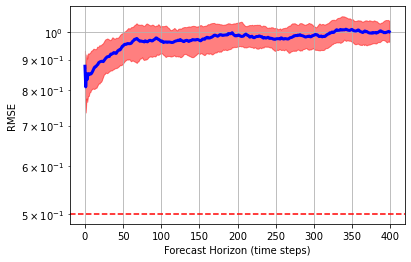

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.893
Median NRMSE at t = 0.5: 0.947
Median NRMSE at t = 1: 0.964
Median NRMSE at t = 2: 0.987
Median NRMSE at t = 3: 0.986


In [18]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.2 hidden_size = [16, 8, 8, 4]

In [15]:
hidden_size = [16, 8, 8, 4]

In [16]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 2.20 | Train loss = 0.8591865 | Val loss =  0.9928596
Epoch 20: Time taken = 2.18 | Train loss = 0.8577556 | Val loss =  1.0064995
Epoch 30: Time taken = 2.26 | Train loss = 0.8554196 | Val loss =  1.0191805
EARLY STOPPING. Epoch 33: Train loss = 0.8531845 | Val loss =  1.0697699
Best Validation MSE: 0.9836946
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 2.34 | Train loss = 0.8586278 | Val loss =  1.0000076
Epoch 20: Time taken = 2.39 | Train loss = 0.8571856 | Val loss =  1.0041647
Epoch 30: Time taken = 2.26 | Train loss = 0.8525196 | Val loss =  1.0381915
EARLY STOPPING. Epoch 33: Train loss = 0.8506649 | Val loss =  1.0612547
Best Validation MSE: 0.9912070

Epoch 10: Time taken = 2.27 | Train loss = 0.8580974 | Val loss =  1.0091746
Epoch 20: Time taken = 2.29 | Train loss = 0.8561718 | Val loss =  1.0219884
Epoch 30: Time taken = 2.35 | Train loss = 0.8499633 | Val loss =  1.0434638
EARLY STOPPING. Epoch 31: Train loss = 0.8492083 |

In [17]:
mean_pred = get_test_pred(X_test, params, network)

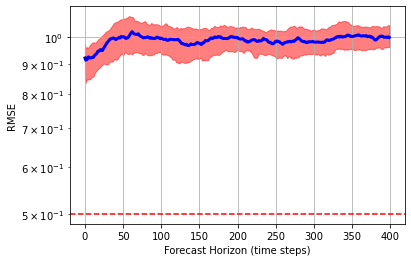

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.953
Median NRMSE at t = 0.5: 1.003
Median NRMSE at t = 1: 0.998
Median NRMSE at t = 2: 1.000
Median NRMSE at t = 3: 0.982


In [19]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.3 hidden_size = [64, 128, 128, 256]

In [15]:
hidden_size = [64, 128, 128, 256]

In [16]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 16.29 | Train loss = 0.0304862 | Val loss =  1.0638562
Epoch 20: Time taken = 16.67 | Train loss = 0.0279036 | Val loss =  3.0295369
Epoch 30: Time taken = 16.06 | Train loss = 0.0120600 | Val loss =  4.4360816
EARLY STOPPING. Epoch 39: Train loss = 0.0078865 | Val loss =  5.1294944
Best Validation MSE: 1.0307390
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 15.22 | Train loss = 0.0282464 | Val loss =  3.2181862
Epoch 20: Time taken = 14.10 | Train loss = 0.0123074 | Val loss =  5.0431456
Epoch 30: Time taken = 14.14 | Train loss = 0.0076447 | Val loss =  5.0269310
EARLY STOPPING. Epoch 33: Train loss = 0.0070387 | Val loss =  4.8937586
Best Validation MSE: 1.0626668

Epoch 10: Time taken = 14.01 | Train loss = 0.0226078 | Val loss =  4.5441295
Epoch 20: Time taken = 13.98 | Train loss = 0.0096992 | Val loss =  6.0705058
Epoch 30: Time taken = 14.02 | Train loss = 0.0069026 | Val loss =  5.1072532
EARLY STOPPING. Epoch 33: Train loss = 0.

In [19]:
mean_pred = get_test_pred(X_test, params, network)

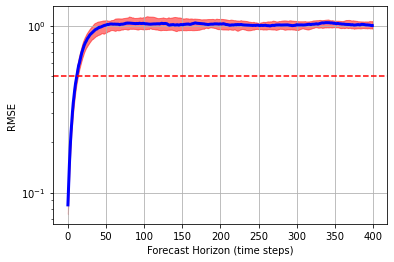

It takes around t = 0.12 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.735
Median NRMSE at t = 0.5: 1.009
Median NRMSE at t = 1: 1.029
Median NRMSE at t = 2: 1.024
Median NRMSE at t = 3: 1.013


In [20]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.4 hidden_size = [32, 24, 24, 16]

In [14]:
hidden_size = [32, 24, 24, 16]

In [15]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 3.05 | Train loss = 0.4857889 | Val loss =  1.1258405
Epoch 20: Time taken = 2.44 | Train loss = 0.4695325 | Val loss =  1.0588766
Epoch 30: Time taken = 2.63 | Train loss = 0.4290789 | Val loss =  1.2720010
EARLY STOPPING. Epoch 32: Train loss = 0.4115355 | Val loss =  1.5812230
Best Validation MSE: 0.9355321
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 3.04 | Train loss = 0.4831610 | Val loss =  0.9611662
Epoch 20: Time taken = 2.58 | Train loss = 0.4630003 | Val loss =  1.1542710
Epoch 30: Time taken = 2.63 | Train loss = 0.4067496 | Val loss =  1.6649258
EARLY STOPPING. Epoch 38: Train loss = 0.3897186 | Val loss =  1.8191222
Best Validation MSE: 0.9429891

Epoch 10: Time taken = 2.69 | Train loss = 0.4644189 | Val loss =  1.0668132
Epoch 20: Time taken = 2.65 | Train loss = 0.4081222 | Val loss =  1.7048265
Epoch 30: Time taken = 2.57 | Train loss = 0.3865562 | Val loss =  1.5927541
EARLY STOPPING. Epoch 31: Train loss = 0.3796763 |

In [16]:
mean_pred = get_test_pred(X_test, params, network)

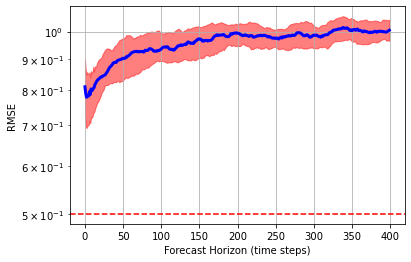

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.841
Median NRMSE at t = 0.5: 0.904
Median NRMSE at t = 1: 0.936
Median NRMSE at t = 2: 0.994
Median NRMSE at t = 3: 0.987


In [17]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.5 hidden_size = [36, 32, 32, 24]

In [19]:
hidden_size = [36, 32, 32, 24]

In [20]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 3.10 | Train loss = 0.3652093 | Val loss =  0.9398078
Epoch 20: Time taken = 2.78 | Train loss = 0.3154778 | Val loss =  0.9675365
Epoch 30: Time taken = 2.80 | Train loss = 0.2916092 | Val loss =  1.1508856
EARLY STOPPING. Epoch 34: Train loss = 0.2616045 | Val loss =  1.3346479
Best Validation MSE: 0.9193701
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 2.77 | Train loss = 0.3360277 | Val loss =  0.9651936
Epoch 20: Time taken = 2.81 | Train loss = 0.3107915 | Val loss =  1.0312526
Epoch 30: Time taken = 2.82 | Train loss = 0.2591640 | Val loss =  1.2789841
EARLY STOPPING. Epoch 33: Train loss = 0.2536910 | Val loss =  1.3150075
Best Validation MSE: 0.9250405

Epoch 10: Time taken = 2.97 | Train loss = 0.3155234 | Val loss =  0.9838487
Epoch 20: Time taken = 2.88 | Train loss = 0.2837492 | Val loss =  1.1293800
Epoch 30: Time taken = 2.74 | Train loss = 0.2517664 | Val loss =  1.2581336
EARLY STOPPING. Epoch 32: Train loss = 0.2495563 |

In [21]:
mean_pred = get_test_pred(X_test, params, network)

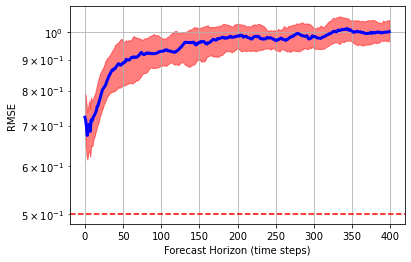

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.778
Median NRMSE at t = 0.5: 0.889
Median NRMSE at t = 1: 0.929
Median NRMSE at t = 2: 0.984
Median NRMSE at t = 3: 0.982


In [22]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.6 hidden_size = [40, 40, 40, 40]

In [23]:
hidden_size = [40, 40, 40, 40]

In [24]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 3.46 | Train loss = 0.2392816 | Val loss =  0.9597871
Epoch 20: Time taken = 3.56 | Train loss = 0.2062408 | Val loss =  0.9721963
Epoch 30: Time taken = 3.48 | Train loss = 0.1949925 | Val loss =  4.6508790
EARLY STOPPING. Epoch 34: Train loss = 0.1877633 | Val loss =  6.4651729
Best Validation MSE: 0.9173611
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 3.17 | Train loss = 0.2097277 | Val loss =  0.9616800
Epoch 20: Time taken = 3.58 | Train loss = 0.1998738 | Val loss =  1.1865869
Epoch 30: Time taken = 3.66 | Train loss = 0.1853905 | Val loss =  6.7415608
EARLY STOPPING. Epoch 34: Train loss = 0.1792107 | Val loss =  7.1292009
Best Validation MSE: 0.9275694

Epoch 10: Time taken = 3.81 | Train loss = 0.2054828 | Val loss =  1.0204917
Epoch 20: Time taken = 3.98 | Train loss = 0.1933887 | Val loss =  5.9328530
Epoch 30: Time taken = 3.68 | Train loss = 0.1771045 | Val loss =  7.0199841
EARLY STOPPING. Epoch 33: Train loss = 0.1727028 |

In [25]:
mean_pred = get_test_pred(X_test, params, network)

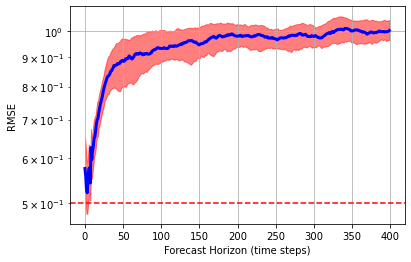

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.743
Median NRMSE at t = 0.5: 0.887
Median NRMSE at t = 1: 0.933
Median NRMSE at t = 2: 0.980
Median NRMSE at t = 3: 0.978


In [26]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

## 3.2 max_lag

In [27]:
loss_weights = [1, 1, .1, .01]
hidden_size = [40, 40, 40, 40]

batch_size = 128
epoch_list = [50, 50, 50]
lr_list = [1e-3, 1e-4, 1e-5]

### 3.2.1 max_lag = 4

In [28]:
max_lag = 4

In [29]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 2.95 | Train loss = 0.2102203 | Val loss =  nan
Epoch 20: Time taken = 3.41 | Train loss = 0.1907626 | Val loss =  6.8037887
Epoch 30: Time taken = 3.06 | Train loss = 0.1733121 | Val loss =  7.7498263
EARLY STOPPING. Epoch 31: Train loss = 0.1725956 | Val loss =  7.8382660
Best Validation MSE: 1.6981004
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 3.16 | Train loss = 0.1931064 | Val loss =  nan
Epoch 20: Time taken = 3.23 | Train loss = 0.1826782 | Val loss =  nan
Epoch 30: Time taken = 3.24 | Train loss = 0.1706528 | Val loss =  nan
EARLY STOPPING. Epoch 31: Train loss = 0.1697365 | Val loss =  nan
Best Validation MSE: 2.5712225

Epoch 10: Time taken = 3.25 | Train loss = 0.1921736 | Val loss =  6.2707271
Epoch 20: Time taken = 3.21 | Train loss = 0.1786095 | Val loss =  nan
Epoch 30: Time taken = 3.24 | Train loss = 0.1693104 | Val loss =  nan
EARLY STOPPING. Epoch 39: Train loss = 0.1625744 | Val loss =  8.4493379
Best Validation MSE

In [30]:
mean_pred = get_test_pred(X_test, params, network)

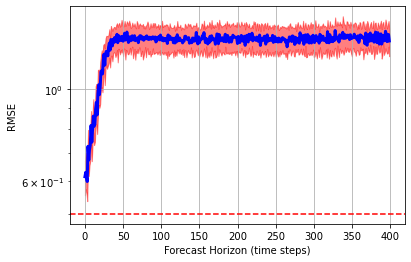

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 1.014
Median NRMSE at t = 0.5: 1.304
Median NRMSE at t = 1: 1.317
Median NRMSE at t = 2: 1.288
Median NRMSE at t = 3: 1.299


In [31]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.2 max_lag = 8
This is already done in 3.1.6

### 3.2.3 max_lag = 16

In [25]:
max_lag = 16

In [26]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 4.63 | Train loss = 0.2996478 | Val loss =  0.9484621
Epoch 20: Time taken = 4.25 | Train loss = 0.2453436 | Val loss =  0.9778289
Epoch 30: Time taken = 4.30 | Train loss = 0.2122493 | Val loss =  1.4639001
EARLY STOPPING. Epoch 37: Train loss = 0.1903976 | Val loss =  1.7583219
Best Validation MSE: 0.9453502
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 4.30 | Train loss = 0.2519582 | Val loss =  1.0279345
Epoch 20: Time taken = 4.25 | Train loss = 0.2164333 | Val loss =  1.2936296
Epoch 30: Time taken = 4.50 | Train loss = 0.1879654 | Val loss =  1.8334517
EARLY STOPPING. Epoch 33: Train loss = 0.1827862 | Val loss =  2.3886850
Best Validation MSE: 0.9355605
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 4.50 | Train loss = 0.2332878 | Val loss =  1.0741872
Epoch 20: Time taken = 4.56 | Train loss = 0.1990626 | Val loss =  1.5711055
Epoch 30: Time taken = 4.55 | Train loss = 0.1805338 | Val loss =  2.3072286
EARLY STOPPING. Epoch 34: 

In [27]:
mean_pred = get_test_pred(X_test, params, network)

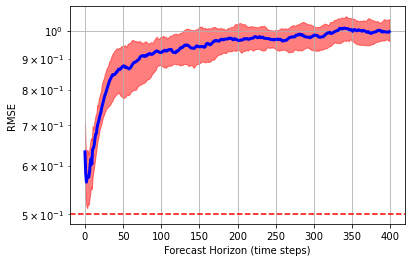

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.728
Median NRMSE at t = 0.5: 0.874
Median NRMSE at t = 1: 0.922
Median NRMSE at t = 2: 0.965
Median NRMSE at t = 3: 0.983


In [28]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.4 max_lag = 24

In [22]:
max_lag = 24

In [23]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 5.34 | Train loss = 0.3519731 | Val loss =  0.9785986
Epoch 20: Time taken = 4.60 | Train loss = 0.3053115 | Val loss =  1.0490331
Epoch 30: Time taken = 4.56 | Train loss = 0.2621952 | Val loss =  1.3512797
EARLY STOPPING. Epoch 31: Train loss = 0.2600132 | Val loss =  1.3228382
Best Validation MSE: 0.9784969
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 4.61 | Train loss = 0.3376305 | Val loss =  0.9946652
Epoch 20: Time taken = 4.33 | Train loss = 0.2931514 | Val loss =  1.0909005
Epoch 30: Time taken = 4.43 | Train loss = 0.2570509 | Val loss =  1.4730132
EARLY STOPPING. Epoch 35: Train loss = 0.2439000 | Val loss =  1.4397519
Best Validation MSE: 0.9738735
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 4.28 | Train loss = 0.3111987 | Val loss =  1.0281311
Epoch 20: Time taken = 4.39 | Train loss = 0.2652772 | Val loss =  1.2820789
Epoch 30: Time taken = 4.24 | Train loss = 0.2419284 | Val loss =  1.3946939
EARLY STOPPING. Epoch 31: 

In [24]:
mean_pred = get_test_pred(X_test, params, network)

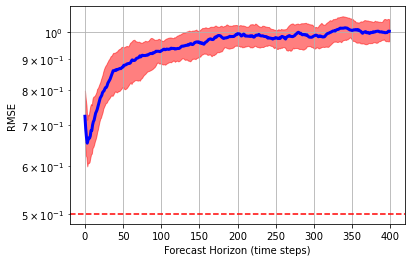

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.777
Median NRMSE at t = 0.5: 0.875
Median NRMSE at t = 1: 0.930
Median NRMSE at t = 2: 0.993
Median NRMSE at t = 3: 0.984


In [25]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.5 max_lag = 32

In [19]:
max_lag = 32

In [20]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 6.63 | Train loss = 0.3912570 | Val loss =  1.0167993
Epoch 20: Time taken = 6.62 | Train loss = 0.3449765 | Val loss =  1.0407477
Epoch 30: Time taken = 6.37 | Train loss = 0.3156296 | Val loss =  1.1068439
EARLY STOPPING. Epoch 31: Train loss = 0.3130902 | Val loss =  1.0865606
Best Validation MSE: 1.0004751
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 6.53 | Train loss = 0.3814200 | Val loss =  1.0177497
Epoch 20: Time taken = 6.29 | Train loss = 0.3406776 | Val loss =  1.0441693
Epoch 30: Time taken = 5.63 | Train loss = 0.3111631 | Val loss =  1.0925543
EARLY STOPPING. Epoch 35: Train loss = 0.2960202 | Val loss =  1.1485845
Best Validation MSE: 1.0040384

Epoch 10: Time taken = 5.16 | Train loss = 0.3482963 | Val loss =  1.0301611
Epoch 20: Time taken = 5.25 | Train loss = 0.3195353 | Val loss =  1.0757346
Epoch 30: Time taken = 5.16 | Train loss = 0.2937664 | Val loss =  1.1768807
EARLY STOPPING. Epoch 38: Train loss = 0.2737425 |

In [21]:
mean_pred = get_test_pred(X_test, params, network)

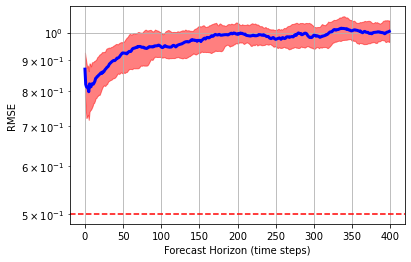

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.855
Median NRMSE at t = 0.5: 0.925
Median NRMSE at t = 1: 0.947
Median NRMSE at t = 2: 0.993
Median NRMSE at t = 3: 0.990


In [22]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

## 3.3 Loss coefficients

In [35]:
hidden_size = [40, 40, 40, 40]
max_lag = 8

batch_size = 128
epoch_list = [50, 50, 50]
lr_list = [1e-3, 1e-4, 1e-5]

### 3.3.1 Base [1, 1, 0.1, 0.01]
This is done in 3.1.6/3.2.2

### 3.3.2 Increased focus on forward loss [1, 2, 0.1, 0.01]

In [36]:
loss_weights = [1, 2, .1, .01]

In [37]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 3.18 | Train loss = 0.3785425 | Val loss =  2.8710917
Epoch 20: Time taken = 3.11 | Train loss = 0.3219538 | Val loss =  4.4411222
Epoch 30: Time taken = 3.51 | Train loss = 0.2796538 | Val loss =  6.3075305
EARLY STOPPING. Epoch 33: Train loss = 0.2711835 | Val loss =  6.3992572
Best Validation MSE: 0.9128680
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 3.10 | Train loss = 0.3664617 | Val loss =  3.7521668
Epoch 20: Time taken = 3.19 | Train loss = 0.2971484 | Val loss =  5.4839826
Epoch 30: Time taken = 3.37 | Train loss = 0.2665274 | Val loss =  6.4013985
EARLY STOPPING. Epoch 31: Train loss = 0.2642024 | Val loss =  6.4467735
Best Validation MSE: 0.9445656

Epoch 10: Time taken = 3.34 | Train loss = 0.3590940 | Val loss =  3.8739220
Epoch 20: Time taken = 3.54 | Train loss = 0.2898901 | Val loss =  5.8627708
Epoch 30: Time taken = 3.55 | Train loss = 0.2617695 | Val loss =  6.5609250
EARLY STOPPING. Epoch 31: Train loss = 0.2594810 |

In [38]:
mean_pred = get_test_pred(X_test, params, network)

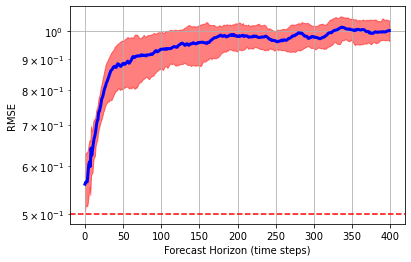

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.748
Median NRMSE at t = 0.5: 0.886
Median NRMSE at t = 1: 0.934
Median NRMSE at t = 2: 0.981
Median NRMSE at t = 3: 0.980


In [39]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.3.3 Only autoencoder and forward loss [1, 1, 0, 0]

In [29]:
hidden_size = [40, 40, 40, 40]
max_lag = 8

batch_size = 128
epoch_list = [50, 50, 50]
lr_list = [1e-3, 1e-4, 1e-5]

In [30]:
loss_weights = [1, 1, 0, 0]

In [31]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 3.42 | Train loss = 0.1584157 | Val loss =  0.9647482
Epoch 20: Time taken = 3.25 | Train loss = 0.1293011 | Val loss =  1.0139397
Epoch 30: Time taken = 3.41 | Train loss = 0.1145397 | Val loss =  0.9775815
EARLY STOPPING. Epoch 31: Train loss = 0.1110092 | Val loss =  0.9853090
Best Validation MSE: 0.9293130
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 3.33 | Train loss = 0.1470196 | Val loss =  1.0354626
Epoch 20: Time taken = 3.47 | Train loss = 0.1228074 | Val loss =  1.0076322
Epoch 30: Time taken = 3.62 | Train loss = 0.1101108 | Val loss =  1.0412222
EARLY STOPPING. Epoch 31: Train loss = 0.1094006 | Val loss =  1.0405123
Best Validation MSE: 0.9309000

Epoch 10: Time taken = 3.62 | Train loss = 0.1397238 | Val loss =  1.0321214
Epoch 20: Time taken = 3.66 | Train loss = 0.1212087 | Val loss =  1.0229633
Epoch 30: Time taken = 3.47 | Train loss = 0.1071596 | Val loss =  1.0337041
EARLY STOPPING. Epoch 34: Train loss = 0.1017177 |

In [32]:
mean_pred = get_test_pred(X_test, params, network)

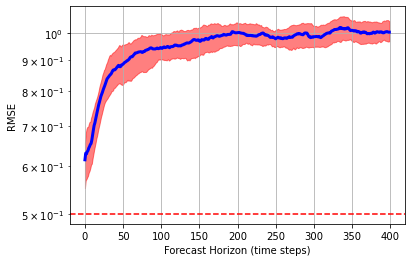

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.777
Median NRMSE at t = 0.5: 0.888
Median NRMSE at t = 1: 0.944
Median NRMSE at t = 2: 1.002
Median NRMSE at t = 3: 0.986


In [33]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.3.4 Equal weightage to forward and backward dynamic [1, 0.5, 0.5, 0.01]

In [26]:
hidden_size = [40, 40, 40, 40]
max_lag = 8

batch_size = 128
epoch_list = [50, 50, 50]
lr_list = [1e-3, 1e-4, 1e-5]

In [27]:
loss_weights = [1, 0.5, 0.5, 0.01]

In [28]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 3.56 | Train loss = 0.2418036 | Val loss =  1.8200065
Epoch 20: Time taken = 3.55 | Train loss = 0.2132567 | Val loss =  5.4989552
Epoch 30: Time taken = 3.71 | Train loss = 0.1798593 | Val loss =  5.9894692
EARLY STOPPING. Epoch 31: Train loss = 0.1762603 | Val loss =  6.1749391
Best Validation MSE: 1.0512778
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 3.48 | Train loss = 0.2332031 | Val loss =  3.5557137
Epoch 20: Time taken = 3.48 | Train loss = 0.2073439 | Val loss =  5.0398654
Epoch 30: Time taken = 3.62 | Train loss = 0.1852937 | Val loss =  6.5999080
EARLY STOPPING. Epoch 33: Train loss = 0.1751750 | Val loss =  6.5225418
Best Validation MSE: 1.8136028

Epoch 10: Time taken = 3.41 | Train loss = 0.2208598 | Val loss =  4.9259192
Epoch 20: Time taken = 3.48 | Train loss = 0.1932614 | Val loss =  6.8940597
Epoch 30: Time taken = 3.51 | Train loss = 0.1675956 | Val loss =  7.2506830
EARLY STOPPING. Epoch 31: Train loss = 0.1644057 |

In [29]:
mean_pred = get_test_pred(X_test, params, network)

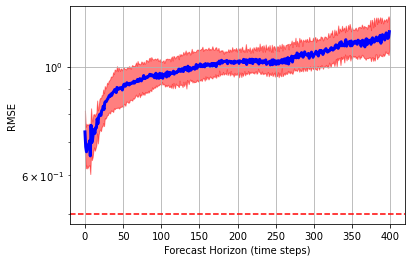

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.800
Median NRMSE at t = 0.5: 0.910
Median NRMSE at t = 1: 0.951
Median NRMSE at t = 2: 1.024
Median NRMSE at t = 3: 1.055


In [30]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.3.5 Increased and Equal weightage to forward and backward dynamic [1, 1, 1, 0.01]

In [23]:
hidden_size = [40, 40, 40, 40]
max_lag = 8

batch_size = 128
epoch_list = [50, 50, 50]
lr_list = [1e-3, 1e-4, 1e-5]

In [24]:
loss_weights = [1, 1, 1, 0.01]

In [25]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 3.78 | Train loss = 0.4315589 | Val loss =  3.3837978
Epoch 20: Time taken = 3.72 | Train loss = 0.3795805 | Val loss =  6.1984606
Epoch 30: Time taken = 3.65 | Train loss = 0.3466478 | Val loss =  6.7197607
EARLY STOPPING. Epoch 31: Train loss = 0.3432365 | Val loss =  6.8634094
Best Validation MSE: 0.9534201
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 3.94 | Train loss = 0.4260401 | Val loss =  3.9527909
Epoch 20: Time taken = 3.28 | Train loss = 0.3760307 | Val loss =  6.4637178
Epoch 30: Time taken = 3.23 | Train loss = 0.3374746 | Val loss =  6.8111832
EARLY STOPPING. Epoch 31: Train loss = 0.3333350 | Val loss =  7.1136074
Best Validation MSE: 1.8968415

Epoch 10: Time taken = 3.45 | Train loss = 0.4127623 | Val loss =  4.8948762
Epoch 20: Time taken = 3.39 | Train loss = 0.3716185 | Val loss =  6.3166356
Epoch 30: Time taken = 3.55 | Train loss = 0.3278926 | Val loss =  6.6612676
EARLY STOPPING. Epoch 31: Train loss = 0.3227468 |

In [26]:
mean_pred = get_test_pred(X_test, params, network)

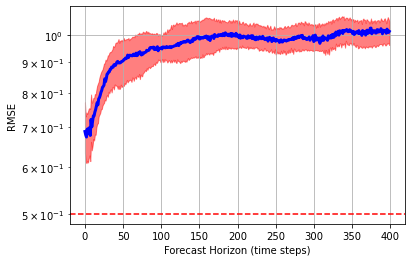

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.792
Median NRMSE at t = 0.5: 0.906
Median NRMSE at t = 1: 0.952
Median NRMSE at t = 2: 1.001
Median NRMSE at t = 3: 0.976


In [27]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

# 4. Final Model

In [12]:
hidden_size = [40, 40, 40, 40]
max_lag = 8
loss_weights = [1, 1, .1, .01]

batch_size = 128
epoch_list = [50, 50, 50]
lr_list = [1e-3, 1e-4, 1e-5]

In [42]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 3.71 | Train loss = 0.2392815 | Val loss =  0.9597870
Epoch 20: Time taken = 3.83 | Train loss = 0.2062408 | Val loss =  0.9721962
Epoch 30: Time taken = 3.73 | Train loss = 0.1949925 | Val loss =  4.6508184
EARLY STOPPING. Epoch 34: Train loss = 0.1877633 | Val loss =  6.4651419
Best Validation MSE: 0.9173610
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 3.82 | Train loss = 0.2097277 | Val loss =  0.9616799
Epoch 20: Time taken = 3.93 | Train loss = 0.1998738 | Val loss =  1.1865861
Epoch 30: Time taken = 3.61 | Train loss = 0.1853904 | Val loss =  6.7412740
EARLY STOPPING. Epoch 34: Train loss = 0.1792105 | Val loss =  7.1273038
Best Validation MSE: 0.9275694

Epoch 10: Time taken = 3.77 | Train loss = 0.2054828 | Val loss =  1.0204917
Epoch 20: Time taken = 3.67 | Train loss = 0.1933887 | Val loss =  5.9328141
Epoch 30: Time taken = 3.72 | Train loss = 0.1771056 | Val loss =  7.0173942
EARLY STOPPING. Epoch 33: Train loss = 0.1727023 |

In [43]:
mean_pred = get_test_pred(X_test, params, network)

In [48]:
save_obj(params, res_folder, "best_params.pkl")

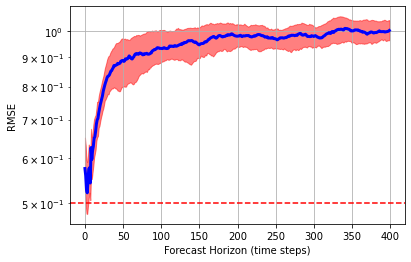

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.743
Median NRMSE at t = 0.5: 0.887
Median NRMSE at t = 1: 0.933
Median NRMSE at t = 2: 0.980
Median NRMSE at t = 3: 0.978


In [45]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

# 5. Plot images based on Lyapunov Time

In [16]:
res_folder = os.path.join("results", "koopman")

In [17]:
def create_network(hidden_size):
    p1, p2, p3, kappa = hidden_size
    encoder_init, encoder = stax.serial(
        Dense(p1), Tanh,  
        Dense(p2), Tanh,
        Dense(p3), Tanh,
        Dense(kappa))
    decoder_init, decoder = stax.serial(
        Dense(p3), Tanh,
        Dense(p2), Tanh,
        Dense(p1), Tanh,
        Dense(data_dim))
    forward_init, forward = stax.serial(
        Dense_no_bias(kappa))
    backward_init, backward = stax.serial(
        Dense_no_bias(kappa))
    network = (encoder, decoder, forward, backward)
    return network

In [18]:
hidden_size = [40, 40, 40, 40]

In [19]:
network = create_network(hidden_size)
params = load_obj(os.path.join(res_folder, "best_params.pkl"))

In [20]:
mean_pred = get_test_pred(X_test, params, network)
save_obj(mean_pred, "results", "koopman_pred.pkl")

Time taken: 1.63


In [9]:
mean_pred = load_obj("results/koopman_pred.pkl")

In [10]:
total_lyapunov_time_pred = 4 / LORENZ_LT # Amount of Lyapunov Time in Test set

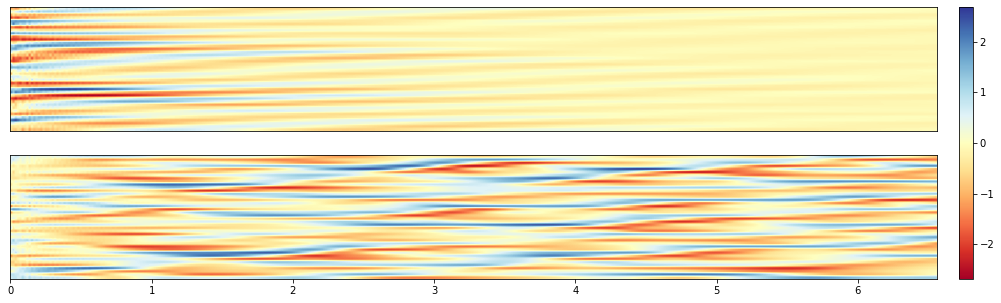

In [11]:
plot_predictions(mean_pred, y_test, total_lyapunov_time_pred, save_name = "lorenz_koop", pred_only = True)

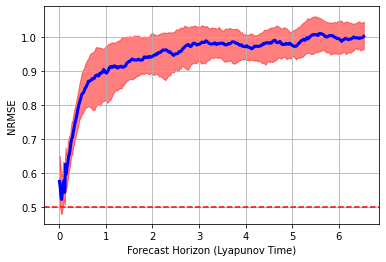

It takes around 0.00 Lyapunov Time for mean error to exceed 0.5

Median NRMSE at 0.5 Lyapunov Time: 0.834
Median NRMSE at 1.0 Lyapunov Time: 0.894
Median NRMSE at 2.0 Lyapunov Time: 0.944
Median NRMSE at 5.0 Lyapunov Time: 0.975


In [12]:
res_single = PointExperimentResultLyapunov(mean_pred - y_test, "lorenz")
res_single.plot_rmse(save_name = "Figure3-8_Koopman_Prediction_Horizon")
print()
res_single.get_loss()